# XDGMM Demo

In this notebook we demonstrate some of the funcitonality of the XDGMM class.

First, import necessary packages. This demo will borrow from the AstroML XD demo written by Jake VanderPlas [here](http://www.astroml.org/book_figures/chapter6/fig_XD_example.html#book-fig-chapter6-fig-xd-example). All fitting will be done with the AstroML algorithm in this demo so that the Bovy et al. algorthim does not need to be installed to run the demo.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from xdgmm import XDGMM

from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import ShuffleSplit

from demo_plots import *

Next, generate some data to use for our fitting and plotting. This generates the same dataset as in the AstroML demo.

In [2]:
N = 2000
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

## Component Selection

We could fit this data directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way this can be determined is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The model with the lowest score is the optimal model to use.

This code will test the performance of the model with n_components ranging from 1 to 10 and produce a figure to display the results. Note that due to the multiple fits, this may take a while to run.

In [ ]:
xdgmm=XDGMM()

param_range = np.array([1,2,3,4,5,6,7,8,9,10])
lowest_bic = np.infty
bic = []
optimal_n_comp = 0

for n_components in param_range:
    xdgmm.n_components = n_components
    xdgmm.fit(X, Xerr)
    bic.append(xdgmm.bic(X,Xerr))
    if bic[-1] < lowest_bic:
        optimal_n_comp = n_components
        lowest_bic = bic[-1]
        best_gmm = xdgmm

bic = np.array(bic)

print bic

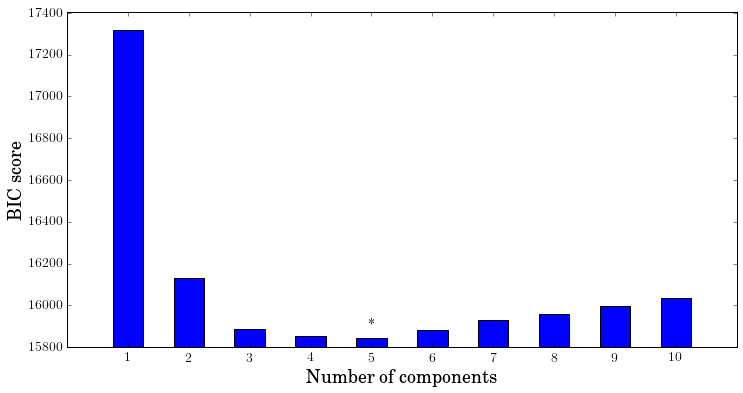

In [4]:
plot_bic(param_range,bic,optimal_n_comp)

### Cross-Validation

Another way to check the number of components to use is to use the scikit-learn cross-valdation methods, which are built into this XDGMM class. BIC is probably a better (and quicker) test of this in most cases, as the log-likelihood (used to score samples) increases with more components, but there should be a point where the model starts overfitting the data. With large datasets with errors, this may be a better test than BIC.

Here we do a cross-validation test with the same number of components and plot a validation curve. As with the BIC test above, this can be a slow process depending on your system, so we have provided the output score means and standard deviations. To rerun the fit, uncomment the indicated block and comment out the lines below.

One important thing to note is the "trick" used to pass errors to the scikit-learn mdethods. Normally for unsupervised learning you would only pass an X array, and not a "target" y array to the validation_curve method. However, we need to pass an error array to our xdgmm.fit method, and validation_curve simply uses the y parameter as the second argument for the fit function. So, by treating the Xerr array as the "target" array, we can pass it to our fit function to fit the data properly.

In [5]:
param_range=[1,2,3,4,5,6,7,8,9,10]
shuffle_split = ShuffleSplit(len(X), 3, test_size=0.3)

# Uncomment this block to rerun the validation curve test.
'''
train_scores,test_scores=validation_curve(xdgmm,X=X,y=Xerr,param_name="n_components",param_range=param_range,n_jobs=3,
                                          cv=shuffle_split,verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
'''

# Comment these lines if rerunning the test.
train_scores_mean = np.array([-6053.19116662, -4658.09407507, -4020.24247642, -3569.36465034, -3243.94564558,
                              -2965.08814495, -2741.16087155, -2552.79400643, -2388.12917351, -2244.33461648])
test_scores_mean = np.array([-2587.37405999, -1996.18628141, -1736.91524941, -1546.16238691, -1401.97936083,
                             -1285.78569238, -1190.13149869, -1110.4551687,  -1041.29912863,  -978.57664357])
train_scores_std = np.array([17.81445431, 9.97349485, 11.77295287, 7.6812774, 11.38402575, 8.05664603, 6.57359385,
                             4.45287531, 3.94064059, 18.09607104])
test_scores_std = np.array([17.62995513, 10.0513458, 7.19617411, 9.06687028, 7.54662107, 10.34478397, 10.06740829,
                            9.79816941, 12.08236001, 9.24544445])

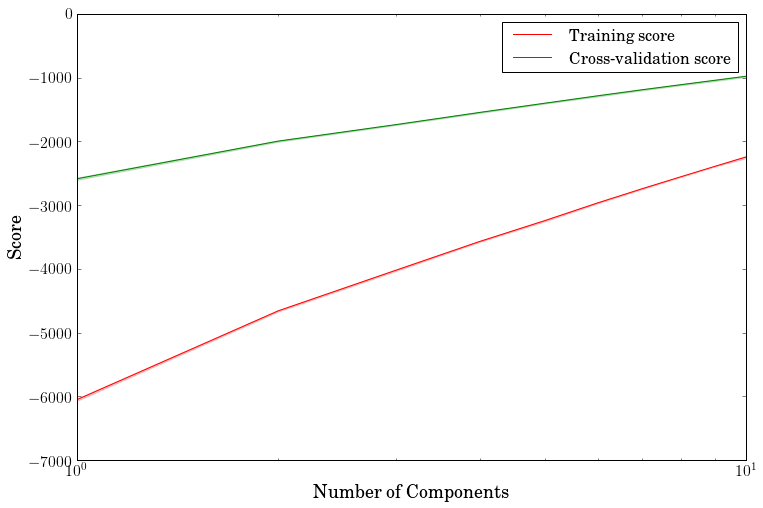

In [4]:
plot_val_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

Based on cross-validation, 10 components is the best choice from the range [1, 10], as the model did not reach a point where it started overfitting the data and the validation curve "turned over." Just to demonstrate what that would look like, here is a test with a much wider range of components. NOTE: this test is very slow, and it is not recommended to rerun.

In [7]:
param_range=[1,10,20,30,40,50,75,100]
xdgmm=XDGMM(method = 'Bovy')

# Uncomment this block to rerun the validation curve test.
'''
train_scores,test_scores=validation_curve(xdgmm,X=X,y=Xerr,param_name="n_components",param_range=param_range,n_jobs=3,\
                                          cv=shuffle_split,verbose=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
'''
train_scores_mean = np.array([-6049.13555593, -2288.49945545, -1367.1280151, -834.20216425, -388.48226494, -82.29024836, 487.95065987, 892.43809363])
train_scores_std = np.array([24.02019595, 48.25877894, 26.63547676, 45.08025294, 17.88446824, 17.90857948, 15.97789688, 10.60871669])
test_scores_mean = np.array([-2591.7077449, -1009.88814176, -634.70262211, -422.12737636, -192.43612842, -54.06064717, 188.87888676, 363.99341488])
test_scores_std = np.array([24.49643971, 39.51195647, 12.05751039, 37.15247669, 17.29274446, 9.94909124, 4.56543115, 2.9610748])

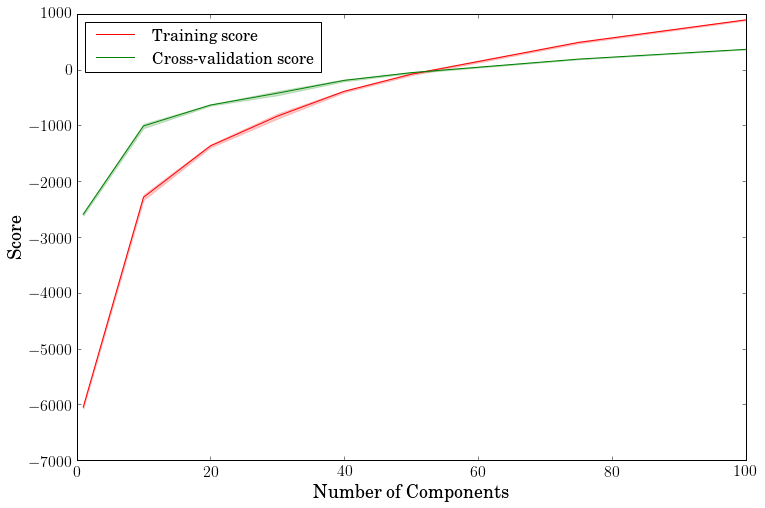

In [10]:
plot_val_curve(param_range, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

Based on these results, it appears that 5 components is the optimal number to model these data.

## Model Fitting

Now that we know the best number of components to use, we can fit the data. First set the number of components, then perform the fit.

In [5]:
xdgmm.n_components = optimal_n_comp
xdgmm = xdgmm.fit(X, Xerr)

## Saving to and Reading from a File

Since fitting the model, even one with only a few components, can be a lengthy process, it can save a lot of time to save the model after fitting so that the same model can be used in the future without the need to re-fit the data. This can be done by calling the save_model() function.

In [6]:
xdgmm.save_model('demo_model.fit')

Once the model is saved, it can be read into an XDGMM object using the read_model() function, or a new XDGMM object can be initialized directly from the saved model file. Note that if both a filename and model parameters are passed to the constructor, the parameters saved in the file will override those passed by the user.

In [3]:
xdgmm=XDGMM(method='astroML')

# Read model into an existing XDGMM object
xdgmm.read_model('demo_model.fit')

# Initialize a new XDGMM object using the model
xdgmm2 = XDGMM(filename='demo_model.fit')

# Comparison --- the arrays should be the same.
print xdgmm.weights
print xdgmm2.weights

[ 0.11536174  0.16720486  0.23959468  0.22087922  0.2569595 ]
[ 0.11536174  0.16720486  0.23959468  0.22087922  0.2569595 ]


## Sampling from the Model

Now that we have a model that has been fit to the data, we can use it to sample data points. Here we sample 2000 points from the model and plot the "true" distribution of the data, the "observed" noisy data, the data generated by the model, and the 1-sigma Gaussian components in the model.

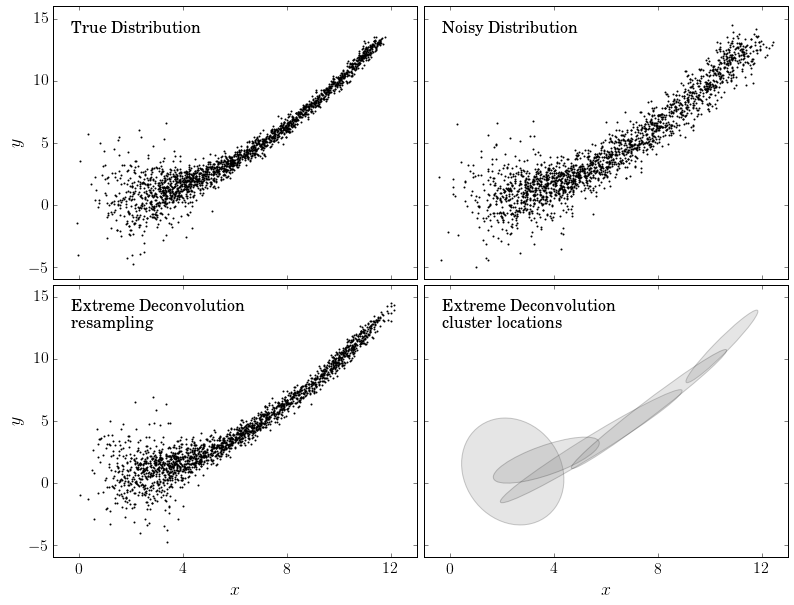

In [8]:
sample = xdgmm.sample(N)

plot_sample(x_true, y_true, x, y, sample, xdgmm)

## Conditioning the Model

One of the key advantages of this implementation of the XDGMM class is that it provides a function for producing a new model from an existing model that is conditioned based on the known values of parameters that were used to fit the original model. The conditioned model can then be used to sample values for the remaining data parameters, essentially providing a way to "fit" those parameters based on the known values of the other parameters.

For our example dataset, let's assume that we have measured the $y$ value to be $1.5\pm0.05$. We can produce a new model for $x$ that is conditioned on $y=1.5\pm0.05$, and use that to sample values of $x$. Note that when condition() is called, any parameters that we do not want included in the conditioning should be set to NaN. The model can be conditioned on values with uncertainties or without; to condition without uncertainty either do not pass an error array or set all the uncertainties equal to $0$.

In [4]:
cond_X = np.array([np.nan, 1.5])
cond_Xerr = np.array([0.0,0.05])
cond_xdgmm = xdgmm.condition(cond_X,cond_Xerr)

# Compare the conditioned model to the original
print xdgmm.weights
print cond_xdgmm.weights
print "\n"
print xdgmm.mu
print cond_xdgmm.mu

[ 0.11536174  0.16720486  0.23959468  0.22087922  0.2569595 ]
[  1.37511447e-01   3.42799342e-10   2.28756903e-01   5.82058947e-01
   5.16727029e-02]


[[  2.41894991   0.91819721]
 [ 10.47436015  11.01034156]
 [  5.44183144   2.95924454]
 [  3.71187571   1.83579255]
 [  7.66279434   5.95823602]]
[[ 2.38023758]
 [ 6.23122843]
 [ 4.35569724]
 [ 3.45552724]
 [ 4.94694899]]


Note how the number of components in the conditioned model has not changed, but that the weights of the components have changed, and the mu array is now 1-dimensional, since $y$ has been conditioned out.

Here we plot the original gaussian components in the $x-y$ plane, a blue line showing $y=1.5$, and a red line showing the new conditioned distribution of $x$ given $y=1.5\pm0.05$.

[[[ 0.97056915 -0.31300103]
  [-0.31300103  4.6540532 ]]

 [[ 0.48064092  0.97955429]
  [ 0.97955429  2.14552362]]

 [[ 3.06438502  3.91028343]
  [ 3.91028343  5.20354946]]

 [[ 1.04183668  0.69799732]
  [ 0.69799732  0.86431131]]

 [[ 2.2384242   3.5406622 ]
  [ 3.5406622   5.76222628]]]


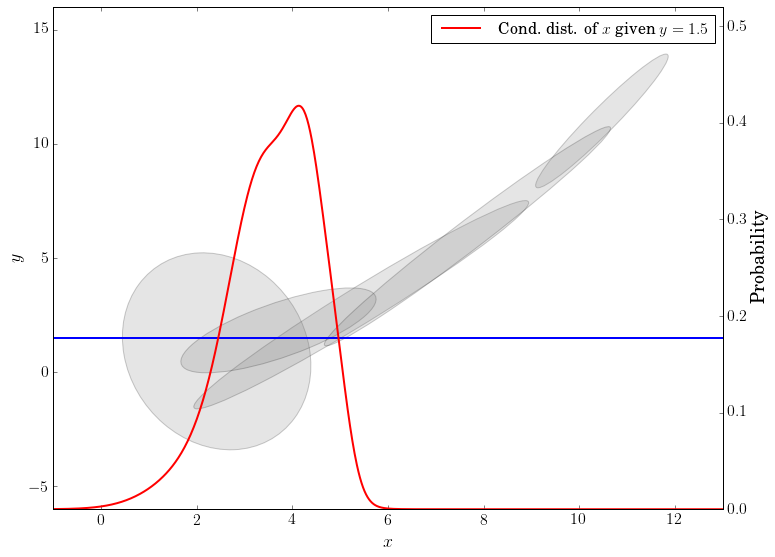

In [9]:
plot_cond_model(xdgmm, cond_xdgmm, 1.5)

If we sample 1000 points from this conditional distribution, we would get something like this:

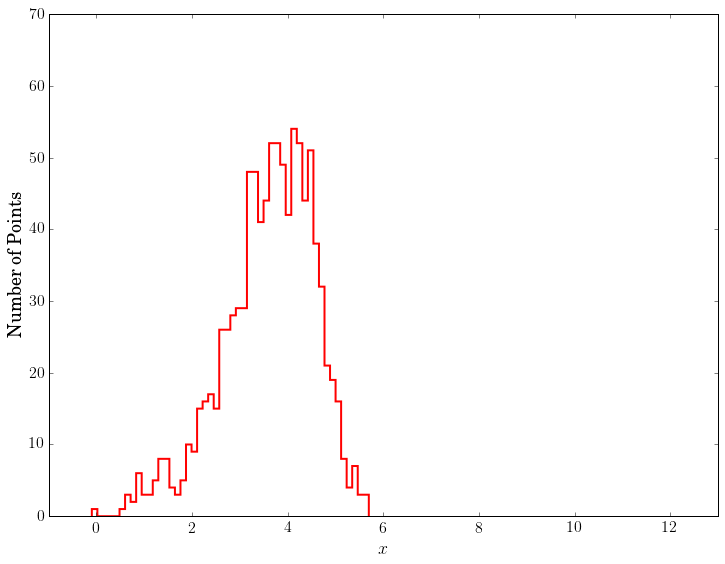

In [10]:
cond_sample = cond_xdgmm.sample(1000)
y = np.ones(1000)*1.5
plot_cond_sample(cond_sample,y)

## Conditioned Fitting

As stated before, one potential use of a conditioned model is to create a "fitting tool" that can fit some parameters using an XDGMM model conditioned on known values of other parameters.

To demonstrate this, here we sample 1000 data points from our model to create a data set to be fit. The $y$ values of this sample will be the "observed" data that we will use to condition the model, and the $x$ values will be the "true" values, which we will compare to the values we fit with the model.

For each $y$ point in this sample, we condition the model based on that value and sample a single $x$ value from the conditioned model. We then plot the fit sample vs. the "true" sample. The distributions should be indistinguishable.

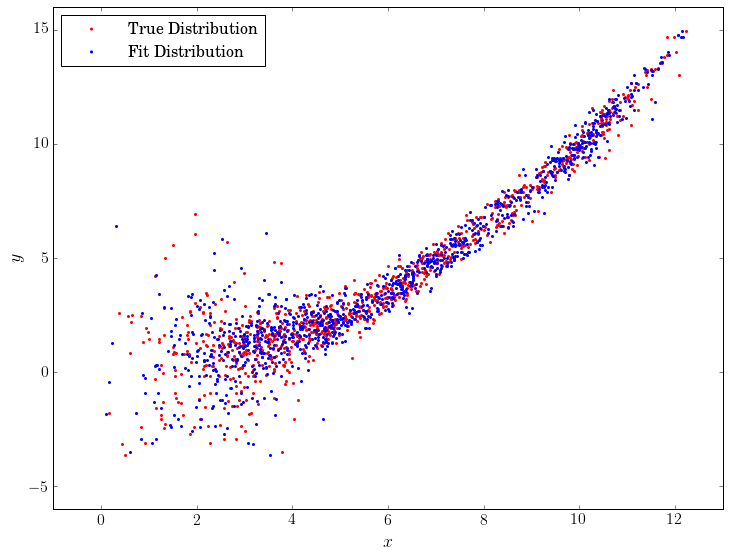

In [5]:
true_sample = xdgmm.sample(1000)
true_x = true_sample[:,0]
y = true_sample[:,1]
fit_x = []

for i in y:
    tmp=np.array([np.nan,i])
    cond_gmm = xdgmm.condition(tmp)
    fit_x.append(cond_gmm.sample())

fit_x = np.array(fit_x)

plot_fit(y, true_x, fit_x)